# Import and load data

In [1]:
from openenergyid.baseload.main import load_energy_data

import pandas as pd

# example_file = "data/PP/energy_use_big.ndjson"
example_file = "data/PP/energy_use_test1.ndjson"
# Load energy data
energy_data = load_energy_data(example_file)

In [2]:
energy = energy_data.collect().to_pandas()
energy = energy.set_index("timestamp").tz_localize("UTC").tz_convert("Europe/Brussels").squeeze()
power = energy * 4
power = power * 1000
power = power.clip(0)
power.name = "power"
power.index.name = None

The input data is a Series of floats. The index is a datetime index; localized and preferably in a 15 minute frequency. It is power, in Watts.

In [3]:
power

2023-01-01 00:00:00+01:00    100.0
2023-01-01 00:15:00+01:00     68.0
2023-01-01 00:30:00+01:00     92.0
2023-01-01 00:45:00+01:00     96.0
2023-01-01 01:00:00+01:00     92.0
                             ...  
2023-12-31 22:45:00+01:00     96.0
2023-12-31 23:00:00+01:00     88.0
2023-12-31 23:15:00+01:00    184.0
2023-12-31 23:30:00+01:00    140.0
2023-12-31 23:45:00+01:00    108.0
Name: power, Length: 35040, dtype: float64

# Analysis

In [4]:
def do_analysis(power: pd.Series, quantile: float, reporting_granularity: str) -> pd.DataFrame:
    # The main baseload number is always calculated on a daily basis
    # It takes the lowest value of the power consumption for each day
    # You can define a quantile, which is the percentage of the lowest values you want to take
    # This is useful if you want to exclude outliers
    # We recommend using a quantile of 0.05, which means that the lowest 5% of the values are taken
    # This corresponds to roughly 1 hour of the lowest values in a day
    baseload = power.resample("D").quantile(quantile)

    consumption_due_to_baseload_in_kilowatthour = (
        baseload.reindex_like(power)
        .ffill()
        .resample("h")
        .mean()
        .resample(reporting_granularity)
        .sum()
        / 1000
    )
    total_consumption_in_kilowatthour = (
        power.resample("h").mean().resample(reporting_granularity).sum() / 1000
    )
    consumption_not_due_to_baseload_in_kilowatthour = (
        total_consumption_in_kilowatthour - consumption_due_to_baseload_in_kilowatthour
    )

    result = pd.DataFrame(
        {
            "consumption_due_to_baseload_in_kilowatthour": consumption_due_to_baseload_in_kilowatthour,
            "consumption_not_due_to_baseload_in_kilowatthour": consumption_not_due_to_baseload_in_kilowatthour,
            "total_consumption_in_kilowatthour": total_consumption_in_kilowatthour,
        }
    )

    if reporting_granularity.lower() in ["h", "15min"]:
        # If the reporting granularity is lower than a day, we need to fill the baseload values
        result["average_daily_baseload_in_watt"] = baseload.reindex_like(result).ffill()
    else:
        # If the reporting granularity is a day or higher, we can just take the mean of the daily baseload values
        result["average_daily_baseload_in_watt"] = baseload.resample(reporting_granularity).mean()

    result["average_power_in_watt"] = power.resample(reporting_granularity).mean()

    result["baseload_ratio"] = (
        result["consumption_due_to_baseload_in_kilowatthour"]
        / result["total_consumption_in_kilowatthour"]
    )
    return result

## Result of an analysis with a Monthly reporting period

In [5]:
do_analysis(power, 0.05, "MS")

,consumption_due_to_baseload_in_kilowatthour,consumption_not_due_to_baseload_in_kilowatthour,total_consumption_in_kilowatthour,average_daily_baseload_in_watt,average_power_in_watt,baseload_ratio
2023-01-01 00:00:00+01:00,54.784128,280.485836,335.269964,73.634581,450.631672,0.163403
2023-02-01 00:00:00+01:00,50.616000,259.397000,310.013000,75.321429,461.328869,0.163271
2023-03-01 00:00:00+01:00,58.812000,290.248000,349.060000,79.161290,469.798116,0.168487
2023-04-01 00:00:00+02:00,55.632000,203.512000,259.144000,77.266667,359.922222,0.214676
2023-05-01 00:00:00+02:00,58.008000,241.308000,299.316000,77.967742,402.306452,0.193802
2023-06-01 00:00:00+02:00,66.336000,222.329000,288.665000,92.133333,400.923611,0.229803
2023-07-01 00:00:00+02:00,51.384000,190.860000,242.244000,69.064516,325.596774,0.212117
2023-08-01 00:00:00+02:00,40.656000,131.412000,172.068000,54.645161,231.274194,0.236279
2023-09-01 00:00:00+02:00,62.856000,254.333000,317.189000,87.300000,440.540278,0.198166
2023-10-01 00:00:00+02:00,57.736000,313.391000,371.127000,77.483871,498.157047,0.155569


## Result of an analysis with a weekly reporting period

In [6]:
do_analysis(power, 0.05, "W-MON")

,consumption_due_to_baseload_in_kilowatthour,consumption_not_due_to_baseload_in_kilowatthour,total_consumption_in_kilowatthour,average_daily_baseload_in_watt,average_power_in_watt,baseload_ratio
2023-01-02 00:00:00+01:00,2.976000,1.558000,4.534000,62.000000,94.458333,0.656374
2023-01-09 00:00:00+01:00,10.312128,45.184836,55.496964,61.381714,330.339071,0.185814
2023-01-16 00:00:00+01:00,13.680000,72.415000,86.095000,81.428571,512.470238,0.158894
2023-01-23 00:00:00+01:00,12.744000,73.363000,86.107000,75.857143,512.541667,0.148002
2023-01-30 00:00:00+01:00,13.464000,75.839000,89.303000,80.142857,531.565476,0.150768
2023-02-06 00:00:00+01:00,12.960000,74.927000,87.887000,77.142857,523.136905,0.147462
2023-02-13 00:00:00+01:00,13.872000,69.702000,83.574000,82.571429,497.464286,0.165985
2023-02-20 00:00:00+01:00,13.248000,64.741000,77.989000,78.857143,464.220238,0.169870
2023-02-27 00:00:00+01:00,10.224000,50.953000,61.177000,60.857143,364.148810,0.167122
2023-03-06 00:00:00+01:00,13.560000,78.320000,91.880000,80.714286,546.904762,0.147584


# Visualize Results

## Monthly

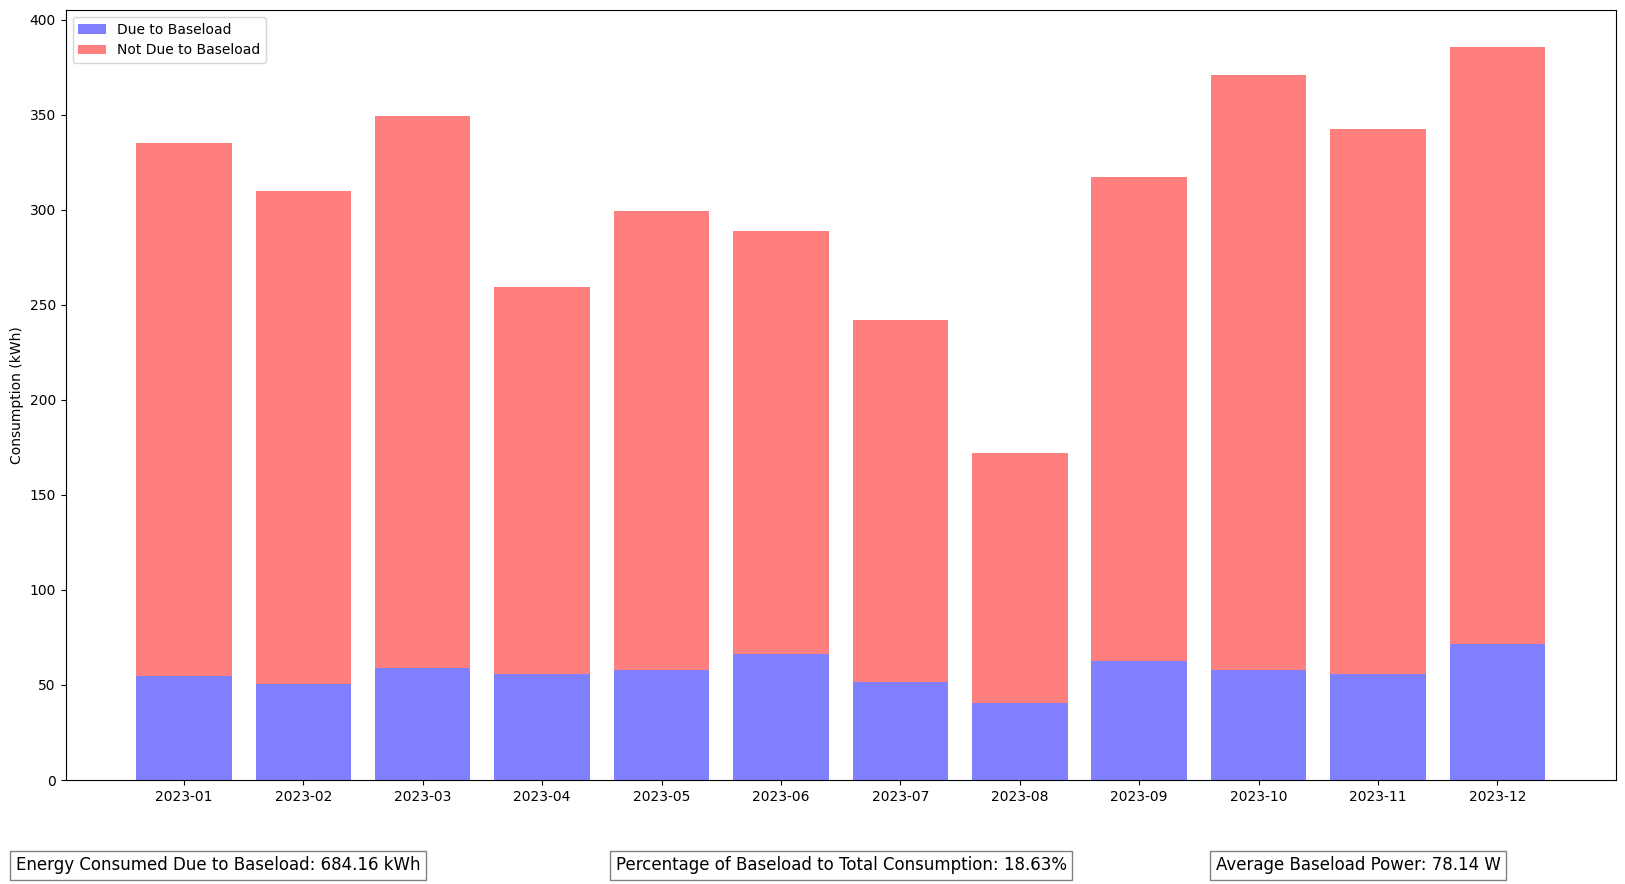

In [7]:
# Make a bar chart with the consumtion due to baseload and the consumption not due to baseload
# On a second y-axis, plot the baseload ratio in %

import matplotlib.pyplot as plt
import numpy as np

result = do_analysis(power, 0.05, "MS")

fig, ax1 = plt.subplots(figsize=(20, 10))

# Define the width of the bars
width = 0.8

# Create an array of positions for the bars
positions = np.arange(len(result))

# Plot the stacked bars
ax1.bar(
    positions,
    result["consumption_due_to_baseload_in_kilowatthour"],
    width=width,
    color="blue",
    alpha=0.5,
    label="Due to Baseload",
)
ax1.bar(
    positions,
    result["consumption_not_due_to_baseload_in_kilowatthour"],
    width=width,
    color="red",
    alpha=0.5,
    bottom=result["consumption_due_to_baseload_in_kilowatthour"],
    label="Not Due to Baseload",
)


# Set the x-axis labels
ax1.set_xticks(positions)
ax1.set_xticklabels(result.index.strftime("%Y-%m"))

# Set the labels
ax1.set_ylabel("Consumption (kWh)")


# Add legends
ax1.legend(loc="upper left")

# Calculate KPIs
total_baseload_consumption = result["consumption_due_to_baseload_in_kilowatthour"].sum()
total_consumption = result["total_consumption_in_kilowatthour"].sum()
percentage_baseload = (total_baseload_consumption / total_consumption) * 100
average_baseload_power = result["average_daily_baseload_in_watt"].mean()

# Add KPI boxes
fig.text(
    0.1,
    0.02,
    f"Energy Consumed Due to Baseload: {total_baseload_consumption:.2f} kWh",
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.5),
)
fig.text(
    0.4,
    0.02,
    f"Percentage of Baseload to Total Consumption: {percentage_baseload:.2f}%",
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.5),
)
fig.text(
    0.7,
    0.02,
    f"Average Baseload Power: {average_baseload_power:.2f} W",
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.5),
)

plt.show()

## Detail of a single month

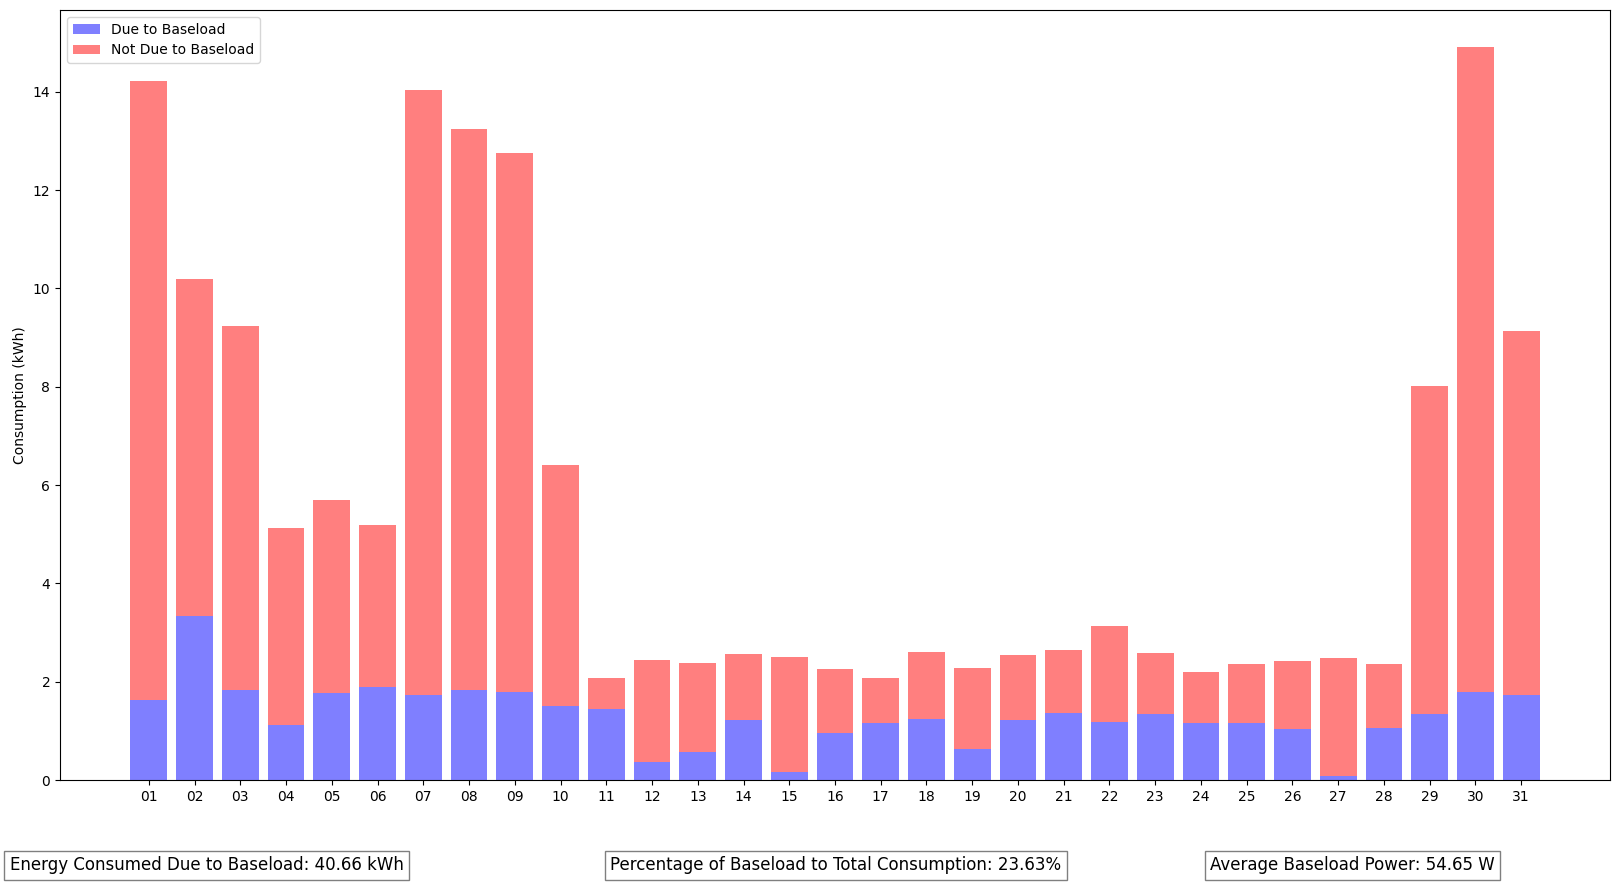

In [8]:
# Zoom in on January 2023 and show the daily baseload

power_august_2023 = power.iloc[(power.index >= "2023-08-01") & (power.index < "2023-09-01")]

result = do_analysis(power_august_2023, 0.05, "D")

fig, ax1 = plt.subplots(figsize=(20, 10))

# Define the width of the bars
width = 0.8

# Create an array of positions for the bars
positions = np.arange(len(result))

# Plot the stacked bars
ax1.bar(
    positions,
    result["consumption_due_to_baseload_in_kilowatthour"],
    width=width,
    color="blue",
    alpha=0.5,
    label="Due to Baseload",
)
ax1.bar(
    positions,
    result["consumption_not_due_to_baseload_in_kilowatthour"],
    width=width,
    color="red",
    alpha=0.5,
    bottom=result["consumption_due_to_baseload_in_kilowatthour"],
    label="Not Due to Baseload",
)


# Set the x-axis labels
ax1.set_xticks(positions)
ax1.set_xticklabels(result.index.strftime("%d"))

# Set the labels
ax1.set_ylabel("Consumption (kWh)")


# Add legends
ax1.legend(loc="upper left")

# Calculate KPIs
total_baseload_consumption = result["consumption_due_to_baseload_in_kilowatthour"].sum()
total_consumption = result["total_consumption_in_kilowatthour"].sum()
percentage_baseload = (total_baseload_consumption / total_consumption) * 100
average_baseload_power = result["average_daily_baseload_in_watt"].mean()

# Add KPI boxes
fig.text(
    0.1,
    0.02,
    f"Energy Consumed Due to Baseload: {total_baseload_consumption:.2f} kWh",
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.5),
)
fig.text(
    0.4,
    0.02,
    f"Percentage of Baseload to Total Consumption: {percentage_baseload:.2f}%",
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.5),
)
fig.text(
    0.7,
    0.02,
    f"Average Baseload Power: {average_baseload_power:.2f} W",
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.5),
)

plt.show()

## Detail of a single Day (But this time in Watts)

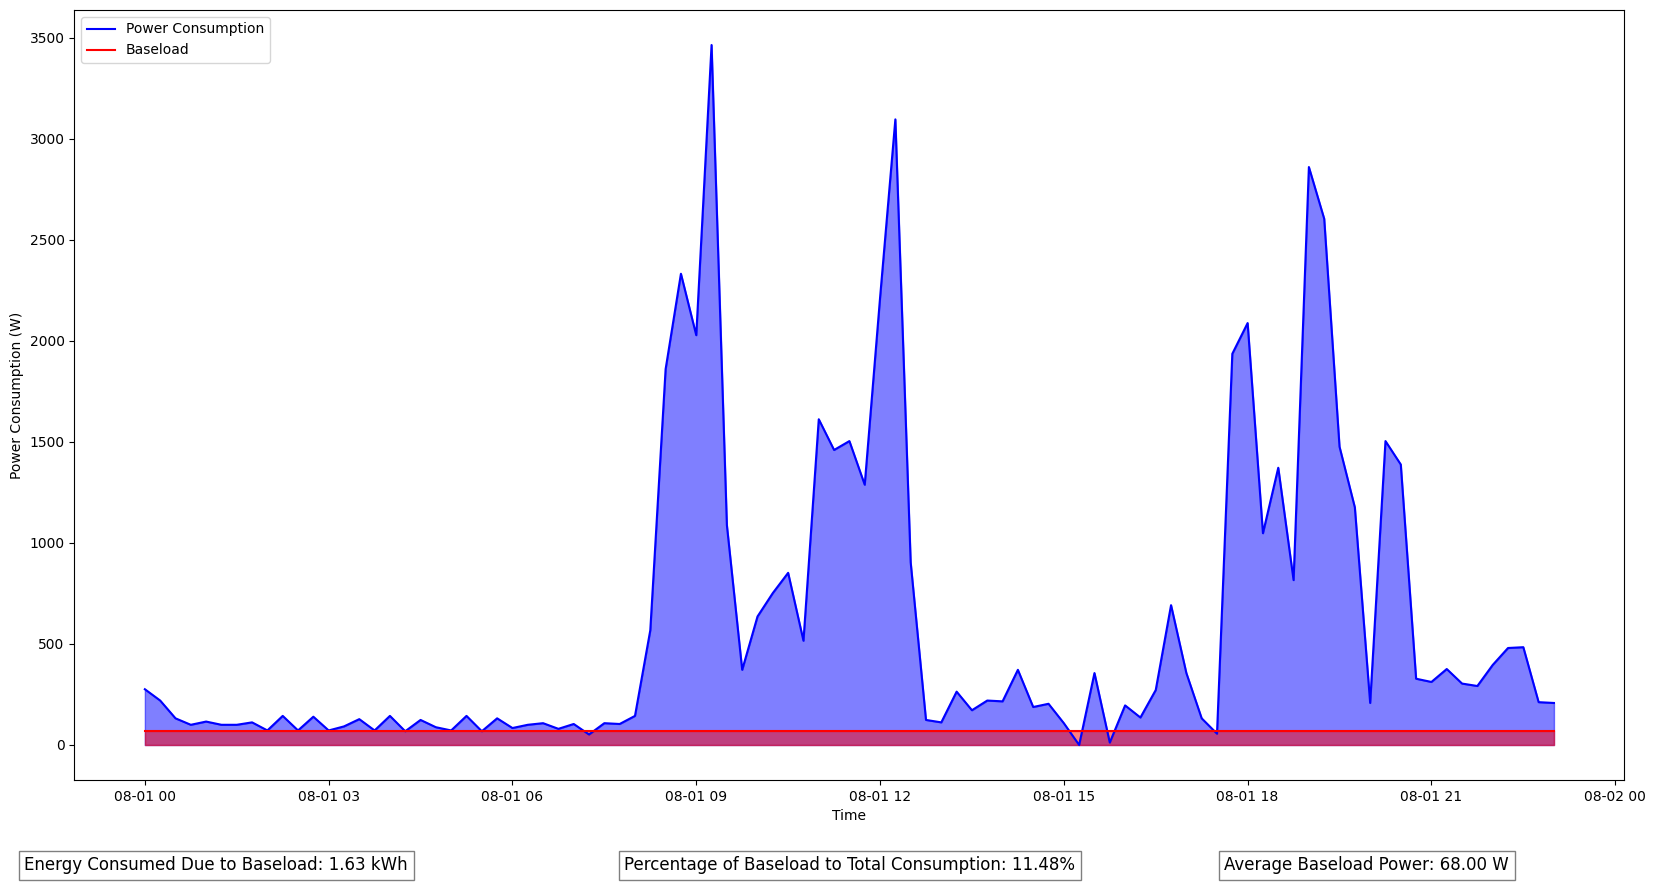

In [9]:
# Now select a single day (e.g. 2023-08-01) and show the power consumption and the baseload (as an area plot)

power_2023_08_01 = power.loc["2023-08-01"]

result = do_analysis(power_2023_08_01, 0.05, "15min")

fig, ax1 = plt.subplots(figsize=(20, 10))

# Plot the power consumption
ax1.plot(result.index, result["average_power_in_watt"], color="blue", label="Power Consumption")
ax1.set_ylabel("Power Consumption (W)")
ax1.set_xlabel("Time")
ax1.legend(loc="upper left")

ax1.plot(result.index, result["average_daily_baseload_in_watt"], color="red", label="Baseload")
ax1.legend(loc="upper left")

# Shade the areas below the curves
ax1.fill_between(result.index, result["average_power_in_watt"], color="blue", alpha=0.5)
ax1.fill_between(result.index, result["average_daily_baseload_in_watt"], color="red", alpha=0.5)

# Add KPIs
total_baseload_consumption = result["consumption_due_to_baseload_in_kilowatthour"].sum()
total_consumption = result["total_consumption_in_kilowatthour"].sum()
percentage_baseload = (total_baseload_consumption / total_consumption) * 100
average_baseload_power = result["average_daily_baseload_in_watt"].mean()

fig.text(
    0.1,
    0.02,
    f"Energy Consumed Due to Baseload: {total_baseload_consumption:.2f} kWh",
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.5),
)
fig.text(
    0.4,
    0.02,
    f"Percentage of Baseload to Total Consumption: {percentage_baseload:.2f}%",
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.5),
)
fig.text(
    0.7,
    0.02,
    f"Average Baseload Power: {average_baseload_power:.2f} W",
    fontsize=12,
    bbox=dict(facecolor="white", alpha=0.5),
)

plt.show()